<h1>Market Simulation</h1>

Get a good understanding of the simulating market before we inject any pricing learning algorithms. Our fundamental assumptions for the two-party market. We try to inject simulated inequalities, so that our algorithms are able to learn optimal pricing, and we can find out if they will converge towards collusive pricing. We will attempt to simulate 3 market conditions: 

1. static markets 
1. dynamic markets 
1. boom or bust markets

The first type of market, static market, will be our baseline. We strip away all noise and distribution shifts and we want to establish a theoretical gap between where rational agents should price and where collusive agents will price. The only differing factor that we will offer between the two firms is the marginal cost of production. Let us assume say the marginal cost of production for Firm A is 1, and for Firm B is 2. We set the max price for the market to be 10, and set the brand quality to be equal


### setup and imports

In [5]:
import sys, os 
import numpy as np
sys.path.append(os.path.abspath(".."))
from market_core import DuopolyEnv 
import matplotlib.pyplot as plt
import seaborn as sns

### static market

In [6]:
config = {
    'market_mode': 'static',
    'production_costs': [1.0, 2.0],
    'quality': [5.0, 5.0],
    'price_sensitivity': 0.8, # Back to standard sensitivity
    'max_price': 8.0,
    'cost_std': 0.0,
    'max_steps': 10000
} 
env = DuopolyEnv(config=config)
env.reset()

(array([0., 0., 0., 1., 2.], dtype=float32), {})

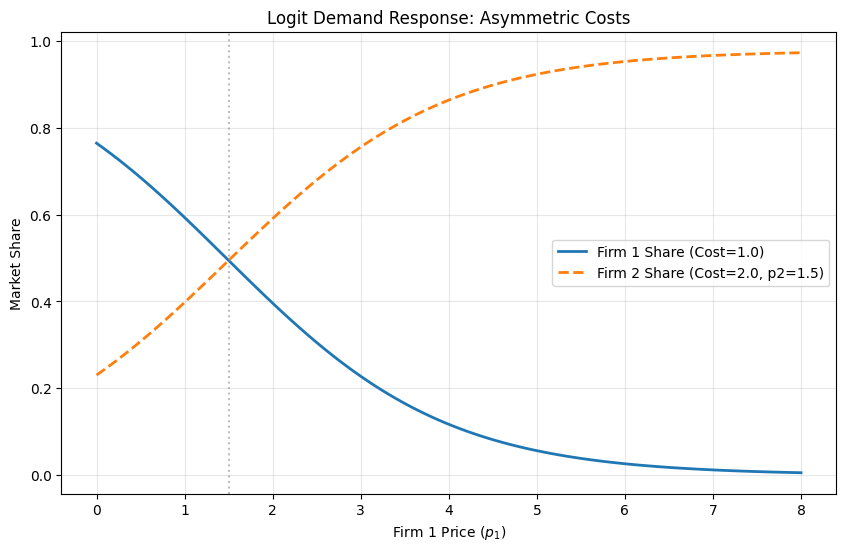

In [8]:
p2_fixed = 1.5 
p1_values = np.linspace(0,8, 100)

share1_list = [] 
share2_list = [] 

for p1 in p1_values: 
    _,_,_,_, info = env.step([p1, p2_fixed])
    shares = info['shares']
    share1_list.append(shares[0])
    share2_list.append(shares[1])

plt.figure(figsize=(10, 6))
plt.plot(p1_values, share1_list, label=f'Firm 1 Share (Cost=1.0)', linewidth=2)
plt.plot(p1_values, share2_list, label=f'Firm 2 Share (Cost=2.0, p2={p2_fixed})', linewidth=2, linestyle='--')

plt.title('Logit Demand Response: Asymmetric Costs')
plt.xlabel('Firm 1 Price ($p_1$)')
plt.ylabel('Market Share')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axvline(x=p2_fixed, color='gray', linestyle=':', alpha=0.5, label='p2 fixed')

plt.show()

    

now plot the game board

In [9]:
c1, c2 = config['production_costs']
q1, q2 = config['quality']
beta = config['price_sensitivity']

resolution = 100 
p_range = np.linspace(0, config['max_price'], resolution)
P1, P2 = np.meshgrid(p_range, p_range)

U1 = q1 - beta * P1 
U2 = q2 - beta * P2 

exp_u1 = np.exp(U1)
exp_u2 = np.exp(U2)
total_exp = 1.0 + exp_u1 + exp_u2 

#market share 
S1 = exp_u1 / total_exp 
S2 = exp_u2 / total_exp 

profit1 = (P1-c1) * S1 
profit2 = (P2-c2) * S2 
joint_profit = profit1 + profit2 

br1_indices = np.argmax(profit1, axis=1)
br1_prices = p_range[br1_indices]

br2_indices = np.argmax(profit2, axis=0)
br2_prices = p_range[br2_indices]

max_joint_idx = np.unravel_index(np.argmax(joint_profit), joint_profit.shape)
p1_coll, p2_coll = P1[max_joint_idx], P2[max_joint_idx]

In [10]:
nash_candidates = []  # list to store (i, j) index pairs that satisfy mutual best response

# Loop over all possible p2 indices (rows in the profit1 / profit2 matrix)
for i, j_best_for_firm1 in enumerate(br1_indices):  # i is index for p2, j_best_for_firm1 is best-response index for p1
    j = j_best_for_firm1  # rename for clarity: j is the candidate p1 index given this p2
    # Check if firm 2's best-response index at this p1 (column j) is exactly this p2 index i
    if br2_indices[j] == i:  # this means (p1_j, p2_i) is a mutual best response
        nash_candidates.append((i, j))  # store the candidate Nash equilibrium indices

# If we found at least one candidate Nash equilibrium on the grid
if nash_candidates:  # checks if the list is non-empty
    i_star, j_star = nash_candidates[0]  # take the first candidate (you can change to pick by some criterion if multiple)
    p1_nash = p_range[j_star]  # firm 1's Nash equilibrium price (column index maps to p_range for p1)
    p2_nash = p_range[i_star]  # firm 2's Nash equilibrium price (row index maps to p_range for p2)
else:
    # No exact intersection on the grid; set to None or handle as "no Nash equilibrium on this discretization"
    p1_nash = None  # indicates no Nash equilibrium found for firm 1 on this grid
    p2_nash = None  # indicates no Nash equilibrium found for firm 2 on this grid

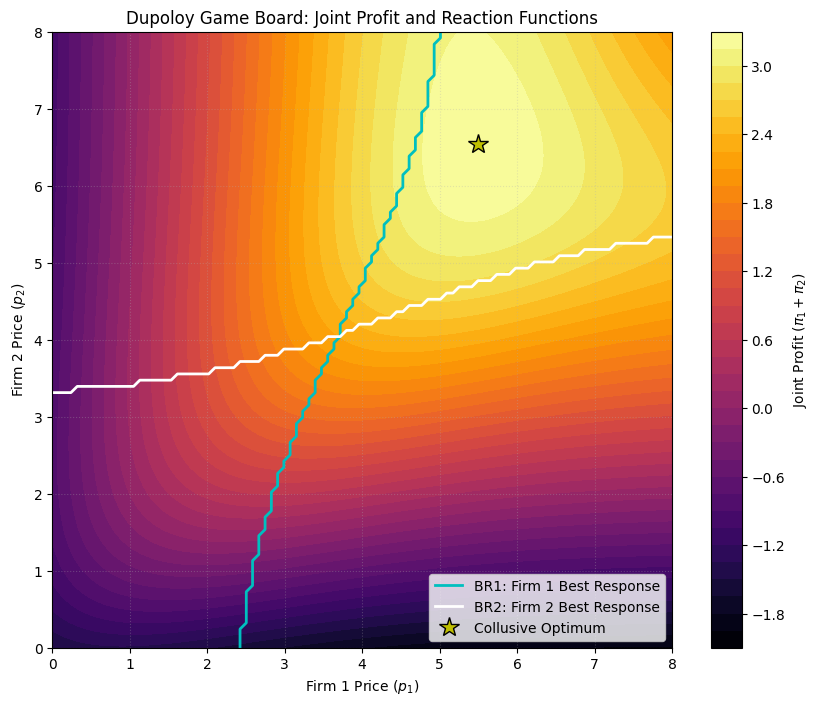

In [11]:
plt.figure(figsize=(10,8))

plt.contourf(P1, P2, joint_profit, levels=50, cmap='inferno')
plt.colorbar(label='Joint Profit ($\pi_1 + \pi_2$)')

#best response 
plt.plot(br1_prices, p_range, 'c-', linewidth=2, label="BR1: Firm 1 Best Response")
plt.plot(p_range, br2_prices, 'w-', linewidth=2, label="BR2: Firm 2 Best Response")

plt.plot(p1_coll, p2_coll, 'y*', markersize=15, markeredgecolor='k', label="Collusive Optimum")

plt.title("Dupoloy Game Board: Joint Profit and Reaction Functions")
plt.xlabel("Firm 1 Price ($p_1$)")
plt.ylabel("Firm 2 Price ($p_2$)")
plt.legend(loc='lower right') 
plt.grid(True, alpha=0.3, linestyle=":")
plt.show()

In [12]:
print("Nash Equilibrium", (p1_nash, p2_nash))
print("Collusive Equilibrium", (p1_coll, p2_coll))

Nash Equilibrium (np.float64(3.7171717171717176), np.float64(4.040404040404041))
Collusive Equilibrium (np.float64(5.494949494949496), np.float64(6.545454545454546))


### dynamic market 1: AR(1) process

### dynamic market 2: Markov Switching Process